In [1]:
import pickle, csv
import numpy as np
import pandas as pd
import networkx as nx
import statistics as s
from math import floor
from tqdm import trange
from NNetwork import NNetwork as nn
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import warnings
warnings.filterwarnings("ignore")
from FCA import *

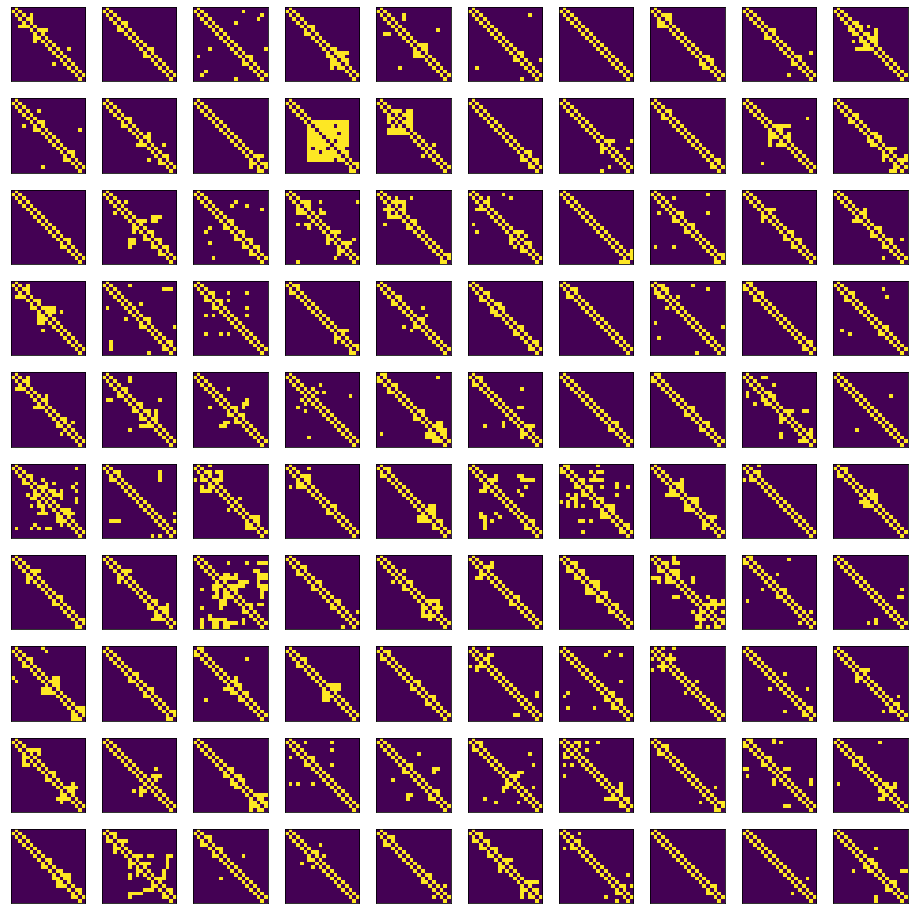

In [2]:
fileo = open('./my_data/UCLA26_20walk_8kappa.pkl', 'rb')
X = pickle.load(fileo)
fileo.close()
display_dictionary(X[:,:100], figsize=[15,15])

In [3]:
df_original = pd.read_csv("./my_data/UCLA26_20walk_8kappa.csv")
df = df_original.copy()
df

,num_edges,num_nodes,min_degree,max_degree,diameter,quartile_1,quartile_2,quartile_3,y,baseline_width,...,s50_11,s50_12,s50_13,s50_14,s50_15,s50_16,s50_17,s50_18,s50_19,s50_20
0,24,20,1,4,12,1.00,4.5,6.0,True,False,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
1,21,20,1,3,17,2.00,3.0,6.5,True,False,...,4.0,3.0,3.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0
2,25,20,1,4,7,2.00,3.5,5.0,False,False,...,2.0,1.0,0.0,6.0,7.0,6.0,6.0,3.0,3.0,2.0
3,26,20,1,5,15,3.25,5.0,6.0,True,False,...,2.0,3.0,4.0,4.0,4.0,4.0,4.0,5.0,5.0,5.0
4,25,20,1,4,8,1.00,4.0,6.0,True,False,...,4.0,4.0,4.0,4.0,4.0,3.0,2.0,4.0,4.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,23,20,1,4,8,2.00,4.5,6.0,False,False,...,3.0,2.0,3.0,4.0,4.0,4.0,5.0,7.0,0.0,1.0
9996,23,20,1,3,16,2.25,5.0,6.0,True,False,...,2.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
9997,22,20,2,3,9,2.00,4.0,6.0,True,True,...,1.0,1.0,0.0,0.0,7.0,6.0,0.0,0.0,7.0,7.0
9998,23,20,1,4,11,1.00,4.5,6.0,True,False,...,6.0,6.0,6.0,6.0,6.0,7.0,0.0,1.0,0.0,2.0


In [4]:
print("shape: ", df.shape)
print("edge mean:", np.mean(df.num_edges))
print("edge std:", np.std(df.num_edges))
print("diameter mean:", np.mean(df.diameter))
print("diameter std:", np.std(df.diameter))
print("===========y==========\n", df.y.value_counts())
print("===========baseline_width==========\n", df.baseline_width.value_counts())

shape:  (10000, 1010)
edge mean: 25.9439
edge std: 4.749163377901461
diameter mean: 11.1812
diameter std: 3.473840318725003
===========y==========
 True     7655
False    2345
Name: y, dtype: int64
===========baseline_width==========
 False    6323
True     3677
Name: baseline_width, dtype: int64


## Input Adjacency matrix

In [5]:
#from SDL_src.LMF import LMF, update_code_within_radius
from SDL_src.SNMF import SNMF
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import random

In [6]:
Y_data = df_original.y
df = pd.DataFrame(X.T)

under_sampler = RandomUnderSampler(random_state=42)
X_res, y_res = under_sampler.fit_resample(df, Y_data)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, 
                                                    test_size = 0.2, 
                                                    random_state = 4, 
                                                    stratify = y_res)

## SDL

In [9]:
xi = 1
iter_avg = 1
beta = 0.5
iteration = 100
r = 10
SNMF_class_new = SNMF(X=[X_train.to_numpy().T, y_train.to_numpy().reshape(-1,1).T],  # data, label
                        X_test=[X_test.to_numpy().T, y_test.to_numpy().reshape(-1,1).T],
                        #X_auxiliary = None,
                        n_components=r,  # =: r = number of columns in dictionary matrices W, W'
                        # ini_loading=None,  # Initializatio for [W,W'], W1.shape = [d1, r], W2.shape = [d2, r]
                        # ini_loading=[W_true, np.hstack((np.array([[0]]), Beta_true))],
                        # ini_code = H_true,
                        xi=xi,  # weight on label reconstruction error
                        L1_reg = [0,0,0], # L1 regularizer for code H, dictionary W[0], reg param W[1]
                        L2_reg = [0,0,0], # L2 regularizer for code H, dictionary W[0], reg param W[1]
                        nonnegativity=[True,True,False], # nonnegativity constraints on code H, dictionary W[0], reg params W[1]
                        full_dim=False)

results_dict_new = SNMF_class_new.train_logistic(iter=iteration, subsample_size=None,
                                                beta = beta,
                                                search_radius_const=np.linalg.norm(X_train),
                                                update_nuance_param=False,
                                                if_compute_recons_error=False, if_validate=False)

  3%|▎         | 3/100 [00:00<00:04, 22.65it/s]

initial loading beta [[-0.43733115 -0.1792355  -0.0416564  -0.31240822  0.07502517  0.55298347
  -0.45902496 -0.94390512  0.98093403  0.08075411  0.10875684]]


100%|██████████| 100/100 [00:04<00:00, 20.52it/s]


In [10]:
results_dict_new

{'xi': 1,
 'L1_reg': [0, 0, 0],
 'L2_reg': [0, 0, 0],
 'nonnegativity': [True, True, False],
 'n_components': 10,
 'loading': [array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 2.34197748e-06, 0.00000000e+00],
         [6.17316516e-02, 2.98124834e-02, 4.42029353e-02, ...,
          3.15569057e-02, 2.52917941e-02, 3.76877555e-02],
         [0.00000000e+00, 0.00000000e+00, 9.80320918e-06, ...,
          0.00000000e+00, 8.01246196e-03, 4.01187919e-02],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [6.18576663e-02, 2.98447367e-02, 4.42591609e-02, ...,
          3.17428594e-02, 2.49061141e-02, 3.76644868e-02],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]),
  array([[-2.39161255, -0.82168411,  1.22938016, -0.3707344 , -0.32274782,
           0.74058717,  0.79663087,  0.26377343,  0.

## NMF

In [11]:
#plotting the dictionary elements(adjacency matrix) as networks and its corresponding degree rank plot
#n: total number of components
#weighted: if true, the degree rank plot is weighted
def plot_DL_adj_deg(n, weighted, filename=None):
    ncol = 8
    nrow = int(np.ceil(n/2))
    fig, axs = plt.subplots(ncols=ncol, nrows=nrow, figsize=(ncol*4, nrow*4))
    
    if weighted:
        for i in range(n):
            df_adj = pd.DataFrame(W_true.T[i].reshape(20, 20))
            G = nx.Graph()
            G = nx.from_pandas_adjacency(df_adj)
            edges = G.edges()
            weights = [80*G[u][v]['weight'] for u,v in edges]
            nx.draw(G, ax=axs[(i//4)*2,i%4], width=weights)
            axs[(i//4)*2,i%4].title.set_text('Synchronizing')
            deg_seq = sorted((d for n, d in G.degree(weight='weight')), reverse=True)
            axs[(i//4)*2+1,i%4].plot(deg_seq, "b-", marker="o")

        for i in range(n):
            df_adj = pd.DataFrame(W_false.T[i].reshape(20, 20))
            G = nx.Graph()
            G = nx.from_pandas_adjacency(df_adj)
            edges = G.edges()
            weights = [80*G[u][v]['weight'] for u,v in edges]
            nx.draw(G, ax=axs[(i//4)*2,i%4+4], width=weights)
            axs[(i//4)*2,i%4+4].title.set_text('Non-Synchronizing')
            deg_seq = sorted((d for n, d in G.degree(weight='weight')), reverse=True)
            axs[(i//4)*2+1,i%4+4].plot(deg_seq, "b-", marker="o")
        if filename != None:
            fig.savefig(filename)
        plt.show()
        
    else:
        for i in range(n):
            df_adj = pd.DataFrame(W_true.T[i].reshape(20, 20))
            G = nx.Graph()
            G = nx.from_pandas_adjacency(df_adj)
            edges = G.edges()
            weights = [80*G[u][v]['weight'] for u,v in edges]
            nx.draw(G, ax=axs[(i//4)*2,i%4], width=weights)
            axs[(i//4)*2,i%4].title.set_text('Synchronizing')
            deg_seq = sorted((d for n, d in G.degree()), reverse=True)
            axs[(i//4)*2+1,i%4].plot(deg_seq, "b-", marker="o")

        for i in range(n):
            df_adj = pd.DataFrame(W_false.T[i].reshape(20, 20))
            G = nx.Graph()
            G = nx.from_pandas_adjacency(df_adj)
            edges = G.edges()
            weights = [80*G[u][v]['weight'] for u,v in edges]
            nx.draw(G, ax=axs[(i//4)*2,i%4+4], width=weights)
            axs[(i//4)*2,i%4+4].title.set_text('Non-Synchronizing')
            deg_seq = sorted((d for n, d in G.degree()), reverse=True)
            axs[(i//4)*2+1,i%4+4].plot(deg_seq, "b-", marker="o")
        if filename != None:
            fig.savefig(filename)
        plt.show()

In [12]:
n = 8
W_false, H = ALS(X=pd.DataFrame(X.T)[df_original.y == 0].to_numpy().T, 
           n_components=n, # Reconstruction Error reduces as n_components increases
           n_iter=1000, 
           a0 = 0, # L1 regularizer for H
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           H_nonnegativity=True,
           W_nonnegativity=True,
           compute_recons_error=True,
           subsample_ratio=1)

W_true, H = ALS(X=pd.DataFrame(X.T)[df_original.y != 0].to_numpy().T, 
           n_components=n, # Reconstruction Error reduces as n_components increases
           n_iter=1000, 
           a0 = 0, # L1 regularizer for H
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           H_nonnegativity=True,
           W_nonnegativity=True,
           compute_recons_error=True,
           subsample_ratio=1)

  2%|▏         | 22/1000 [00:00<00:09, 104.84it/s]

iteration 0, reconstruction error 120006.529913
iteration 10, reconstruction error 33747.443392
iteration 20, reconstruction error 38344.078381


  5%|▍         | 46/1000 [00:00<00:08, 112.02it/s]

iteration 30, reconstruction error 38296.879727
iteration 40, reconstruction error 36004.450391
iteration 50, reconstruction error 31491.773836


  8%|▊         | 82/1000 [00:00<00:08, 113.05it/s]

iteration 60, reconstruction error 27732.481061
iteration 70, reconstruction error 26730.884300
iteration 80, reconstruction error 26289.196830


 11%|█         | 106/1000 [00:00<00:07, 113.57it/s]

iteration 90, reconstruction error 25929.254910
iteration 100, reconstruction error 25609.865255
iteration 110, reconstruction error 25335.892049


 14%|█▍        | 142/1000 [00:01<00:07, 108.27it/s]

iteration 120, reconstruction error 25122.558102
iteration 130, reconstruction error 24968.550570
iteration 140, reconstruction error 24856.545370


 16%|█▋        | 164/1000 [00:01<00:07, 108.18it/s]

iteration 150, reconstruction error 24771.634205
iteration 160, reconstruction error 24703.764542
iteration 170, reconstruction error 24646.213624


 20%|██        | 201/1000 [00:01<00:07, 113.96it/s]

iteration 180, reconstruction error 24595.502265
iteration 190, reconstruction error 24549.665039
iteration 200, reconstruction error 24507.190645


 22%|██▎       | 225/1000 [00:02<00:06, 112.60it/s]

iteration 210, reconstruction error 24467.499694
iteration 220, reconstruction error 24430.248169
iteration 230, reconstruction error 24395.404081


 26%|██▌       | 261/1000 [00:02<00:06, 112.75it/s]

iteration 240, reconstruction error 24363.123461
iteration 250, reconstruction error 24333.403625
iteration 260, reconstruction error 24306.180679


 28%|██▊       | 285/1000 [00:02<00:06, 113.61it/s]

iteration 270, reconstruction error 24281.531636
iteration 280, reconstruction error 24259.442072
iteration 290, reconstruction error 24239.857816


 32%|███▏      | 321/1000 [00:02<00:06, 111.28it/s]

iteration 300, reconstruction error 24222.632096
iteration 310, reconstruction error 24207.559571
iteration 320, reconstruction error 24194.459071


 34%|███▍      | 345/1000 [00:03<00:06, 104.90it/s]

iteration 330, reconstruction error 24183.171353
iteration 340, reconstruction error 24173.434975


 37%|███▋      | 367/1000 [00:03<00:06, 101.63it/s]

iteration 350, reconstruction error 24165.015555
iteration 360, reconstruction error 24157.726225
iteration 370, reconstruction error 24151.393609


 40%|████      | 400/1000 [00:03<00:05, 101.54it/s]

iteration 380, reconstruction error 24145.875986
iteration 390, reconstruction error 24141.045325
iteration 400, reconstruction error 24136.799086


 42%|████▏     | 422/1000 [00:03<00:05, 105.03it/s]

iteration 410, reconstruction error 24133.037564
iteration 420, reconstruction error 24129.687059
iteration 430, reconstruction error 24126.689461


 46%|████▌     | 455/1000 [00:04<00:05, 104.98it/s]

iteration 440, reconstruction error 24123.968872
iteration 450, reconstruction error 24121.465417
iteration 460, reconstruction error 24119.134296


 49%|████▉     | 490/1000 [00:04<00:04, 111.96it/s]

iteration 470, reconstruction error 24116.937803
iteration 480, reconstruction error 24114.855096
iteration 490, reconstruction error 24112.862437


 51%|█████▏    | 514/1000 [00:04<00:04, 109.50it/s]

iteration 500, reconstruction error 24110.941937
iteration 510, reconstruction error 24109.092889
iteration 520, reconstruction error 24107.303956


 55%|█████▌    | 550/1000 [00:05<00:04, 105.31it/s]

iteration 530, reconstruction error 24105.561096
iteration 540, reconstruction error 24103.855511


 56%|█████▌    | 561/1000 [00:05<00:04, 103.34it/s]

iteration 550, reconstruction error 24102.183729
iteration 560, reconstruction error 24100.543172
iteration 570, reconstruction error 24098.929239


 59%|█████▉    | 593/1000 [00:05<00:04, 98.46it/s] 

iteration 580, reconstruction error 24097.341908
iteration 590, reconstruction error 24095.784712


 62%|██████▏   | 615/1000 [00:05<00:03, 103.03it/s]

iteration 600, reconstruction error 24094.258866
iteration 610, reconstruction error 24092.768512
iteration 620, reconstruction error 24091.319018


 65%|██████▌   | 651/1000 [00:06<00:03, 111.25it/s]

iteration 630, reconstruction error 24089.913772
iteration 640, reconstruction error 24088.558856
iteration 650, reconstruction error 24087.255302


 68%|██████▊   | 675/1000 [00:06<00:02, 112.57it/s]

iteration 660, reconstruction error 24086.006266
iteration 670, reconstruction error 24084.815222
iteration 680, reconstruction error 24083.688087


 71%|███████   | 710/1000 [00:06<00:02, 103.11it/s]

iteration 690, reconstruction error 24082.626152
iteration 700, reconstruction error 24081.629093


 72%|███████▏  | 722/1000 [00:06<00:02, 105.16it/s]

iteration 710, reconstruction error 24080.697882
iteration 720, reconstruction error 24079.830999
iteration 730, reconstruction error 24079.025619


 76%|███████▌  | 759/1000 [00:07<00:02, 111.37it/s]

iteration 740, reconstruction error 24078.278333
iteration 750, reconstruction error 24077.588282
iteration 760, reconstruction error 24076.949974


 78%|███████▊  | 783/1000 [00:07<00:01, 111.69it/s]

iteration 770, reconstruction error 24076.359258
iteration 780, reconstruction error 24075.812636
iteration 790, reconstruction error 24075.306244


 82%|████████▏ | 819/1000 [00:07<00:01, 111.03it/s]

iteration 800, reconstruction error 24074.836681
iteration 810, reconstruction error 24074.401202
iteration 820, reconstruction error 24073.996589


 84%|████████▍ | 843/1000 [00:07<00:01, 110.17it/s]

iteration 830, reconstruction error 24073.620221
iteration 840, reconstruction error 24073.269599
iteration 850, reconstruction error 24072.942595


 88%|████████▊ | 879/1000 [00:08<00:01, 110.70it/s]

iteration 860, reconstruction error 24072.642286
iteration 870, reconstruction error 24072.369779
iteration 880, reconstruction error 24072.119794


 90%|█████████ | 902/1000 [00:08<00:00, 106.84it/s]

iteration 890, reconstruction error 24071.888903
iteration 900, reconstruction error 24071.674310
iteration 910, reconstruction error 24071.473926


 94%|█████████▎| 936/1000 [00:08<00:00, 110.15it/s]

iteration 920, reconstruction error 24071.286309
iteration 930, reconstruction error 24071.110200
iteration 940, reconstruction error 24070.944453


 97%|█████████▋| 972/1000 [00:08<00:00, 110.97it/s]

iteration 950, reconstruction error 24070.788114
iteration 960, reconstruction error 24070.640379
iteration 970, reconstruction error 24070.500504


  0%|          | 0/1000 [00:00<?, ?it/s]

iteration 980, reconstruction error 24070.367877
iteration 990, reconstruction error 24070.241970


  1%|          | 7/1000 [00:00<00:30, 32.97it/s]

iteration 0, reconstruction error 395291.875322


  2%|▏         | 15/1000 [00:00<00:29, 33.66it/s]

iteration 10, reconstruction error 112720.159604


  3%|▎         | 27/1000 [00:00<00:28, 33.72it/s]

iteration 20, reconstruction error 120702.090081


  4%|▎         | 35/1000 [00:01<00:28, 33.50it/s]

iteration 30, reconstruction error 107711.756304


  5%|▍         | 47/1000 [00:01<00:28, 33.96it/s]

iteration 40, reconstruction error 92011.298676


  6%|▌         | 55/1000 [00:01<00:27, 34.33it/s]

iteration 50, reconstruction error 86891.317908


  7%|▋         | 67/1000 [00:01<00:26, 35.51it/s]

iteration 60, reconstruction error 84916.029070


  8%|▊         | 75/1000 [00:02<00:26, 34.51it/s]

iteration 70, reconstruction error 83380.741163


  9%|▊         | 87/1000 [00:02<00:26, 34.48it/s]

iteration 80, reconstruction error 82380.674480


 10%|▉         | 95/1000 [00:02<00:26, 34.22it/s]

iteration 90, reconstruction error 81659.459626


 11%|█         | 107/1000 [00:03<00:26, 33.90it/s]

iteration 100, reconstruction error 81019.436379


 12%|█▏        | 115/1000 [00:03<00:26, 33.31it/s]

iteration 110, reconstruction error 80395.236707


 13%|█▎        | 127/1000 [00:03<00:25, 34.37it/s]

iteration 120, reconstruction error 79811.188074


 14%|█▎        | 135/1000 [00:04<00:25, 33.85it/s]

iteration 130, reconstruction error 79300.708723


 15%|█▍        | 147/1000 [00:04<00:24, 34.19it/s]

iteration 140, reconstruction error 78865.543597


 16%|█▌        | 155/1000 [00:04<00:24, 34.47it/s]

iteration 150, reconstruction error 78500.106301


 17%|█▋        | 167/1000 [00:04<00:23, 34.77it/s]

iteration 160, reconstruction error 78193.716542


 18%|█▊        | 175/1000 [00:05<00:24, 34.07it/s]

iteration 170, reconstruction error 77931.396233


 19%|█▊        | 187/1000 [00:05<00:23, 34.99it/s]

iteration 180, reconstruction error 77704.792548


 20%|█▉        | 195/1000 [00:05<00:23, 34.04it/s]

iteration 190, reconstruction error 77508.239496


 21%|██        | 207/1000 [00:06<00:23, 34.39it/s]

iteration 200, reconstruction error 77336.825160


 22%|██▏       | 215/1000 [00:06<00:23, 33.50it/s]

iteration 210, reconstruction error 77187.051859


 23%|██▎       | 227/1000 [00:06<00:22, 35.02it/s]

iteration 220, reconstruction error 77056.040917


 24%|██▎       | 235/1000 [00:06<00:22, 34.76it/s]

iteration 230, reconstruction error 76940.806839


 25%|██▍       | 247/1000 [00:07<00:21, 35.40it/s]

iteration 240, reconstruction error 76838.653701


 26%|██▌       | 255/1000 [00:07<00:21, 35.04it/s]

iteration 250, reconstruction error 76747.710018


 27%|██▋       | 267/1000 [00:07<00:20, 35.55it/s]

iteration 260, reconstruction error 76668.012487


 28%|██▊       | 275/1000 [00:08<00:20, 35.21it/s]

iteration 270, reconstruction error 76599.454323


 29%|██▊       | 287/1000 [00:08<00:20, 35.51it/s]

iteration 280, reconstruction error 76540.980131


 30%|██▉       | 295/1000 [00:08<00:20, 35.08it/s]

iteration 290, reconstruction error 76490.890941


 31%|███       | 307/1000 [00:08<00:19, 35.31it/s]

iteration 300, reconstruction error 76447.613496


 32%|███▏      | 315/1000 [00:09<00:19, 35.07it/s]

iteration 310, reconstruction error 76409.982551


 33%|███▎      | 327/1000 [00:09<00:19, 34.70it/s]

iteration 320, reconstruction error 76377.039879


 34%|███▎      | 335/1000 [00:09<00:19, 33.66it/s]

iteration 330, reconstruction error 76347.678596


 35%|███▍      | 347/1000 [00:10<00:20, 32.10it/s]

iteration 340, reconstruction error 76321.305441


 36%|███▌      | 355/1000 [00:10<00:19, 32.36it/s]

iteration 350, reconstruction error 76297.691002


 37%|███▋      | 367/1000 [00:10<00:19, 32.71it/s]

iteration 360, reconstruction error 76276.536588


 38%|███▊      | 375/1000 [00:11<00:19, 32.87it/s]

iteration 370, reconstruction error 76257.588850


 39%|███▊      | 387/1000 [00:11<00:18, 33.06it/s]

iteration 380, reconstruction error 76240.658362


 40%|███▉      | 395/1000 [00:11<00:20, 29.70it/s]

iteration 390, reconstruction error 76225.586505


 41%|████      | 407/1000 [00:12<00:17, 33.35it/s]

iteration 400, reconstruction error 76212.230683


 42%|████▏     | 415/1000 [00:12<00:17, 33.92it/s]

iteration 410, reconstruction error 76200.398989


 43%|████▎     | 427/1000 [00:12<00:16, 34.99it/s]

iteration 420, reconstruction error 76189.939378


 44%|████▎     | 435/1000 [00:12<00:16, 34.89it/s]

iteration 430, reconstruction error 76180.711748


 45%|████▍     | 447/1000 [00:13<00:15, 35.46it/s]

iteration 440, reconstruction error 76172.584569


 46%|████▌     | 455/1000 [00:13<00:15, 34.98it/s]

iteration 450, reconstruction error 76165.413977


 47%|████▋     | 467/1000 [00:13<00:16, 32.11it/s]

iteration 460, reconstruction error 76159.076363


 48%|████▊     | 475/1000 [00:14<00:16, 31.32it/s]

iteration 470, reconstruction error 76153.468491


 49%|████▊     | 487/1000 [00:14<00:15, 32.20it/s]

iteration 480, reconstruction error 76148.474878


 50%|████▉     | 495/1000 [00:14<00:15, 33.46it/s]

iteration 490, reconstruction error 76144.013682


 51%|█████     | 507/1000 [00:15<00:14, 34.24it/s]

iteration 500, reconstruction error 76140.007873


 52%|█████▏    | 515/1000 [00:15<00:14, 33.41it/s]

iteration 510, reconstruction error 76136.390236


 53%|█████▎    | 527/1000 [00:15<00:15, 31.44it/s]

iteration 520, reconstruction error 76133.091839


 54%|█████▎    | 535/1000 [00:15<00:14, 31.10it/s]

iteration 530, reconstruction error 76130.055830


 55%|█████▍    | 547/1000 [00:16<00:14, 31.83it/s]

iteration 540, reconstruction error 76127.228943


 56%|█████▌    | 555/1000 [00:16<00:14, 31.63it/s]

iteration 550, reconstruction error 76124.570036


 57%|█████▋    | 567/1000 [00:16<00:13, 32.95it/s]

iteration 560, reconstruction error 76122.041487


 57%|█████▊    | 575/1000 [00:17<00:12, 33.41it/s]

iteration 570, reconstruction error 76119.614210


 59%|█████▊    | 587/1000 [00:17<00:11, 34.73it/s]

iteration 580, reconstruction error 76117.259776


 60%|█████▉    | 595/1000 [00:17<00:11, 34.66it/s]

iteration 590, reconstruction error 76114.958140


 61%|██████    | 607/1000 [00:18<00:11, 35.35it/s]

iteration 600, reconstruction error 76112.690169


 62%|██████▏   | 615/1000 [00:18<00:11, 34.98it/s]

iteration 610, reconstruction error 76110.439516


 63%|██████▎   | 627/1000 [00:18<00:10, 35.36it/s]

iteration 620, reconstruction error 76108.194953


 64%|██████▎   | 635/1000 [00:18<00:10, 34.88it/s]

iteration 630, reconstruction error 76105.948276


 65%|██████▍   | 647/1000 [00:19<00:10, 35.09it/s]

iteration 640, reconstruction error 76103.692716


 66%|██████▌   | 655/1000 [00:19<00:09, 34.95it/s]

iteration 650, reconstruction error 76101.421140


 67%|██████▋   | 667/1000 [00:19<00:09, 35.28it/s]

iteration 660, reconstruction error 76099.124950


 68%|██████▊   | 675/1000 [00:20<00:09, 35.10it/s]

iteration 670, reconstruction error 76096.798737


 69%|██████▊   | 687/1000 [00:20<00:08, 35.37it/s]

iteration 680, reconstruction error 76094.437855


 70%|██████▉   | 695/1000 [00:20<00:08, 34.95it/s]

iteration 690, reconstruction error 76092.037858


 71%|███████   | 707/1000 [00:20<00:08, 35.08it/s]

iteration 700, reconstruction error 76089.594266


 72%|███████▏  | 715/1000 [00:21<00:08, 34.89it/s]

iteration 710, reconstruction error 76087.105270


 73%|███████▎  | 727/1000 [00:21<00:07, 35.22it/s]

iteration 720, reconstruction error 76084.600285


 74%|███████▎  | 735/1000 [00:21<00:07, 34.69it/s]

iteration 730, reconstruction error 76082.081394


 75%|███████▍  | 747/1000 [00:22<00:07, 34.27it/s]

iteration 740, reconstruction error 76079.546400


 76%|███████▌  | 755/1000 [00:22<00:07, 33.47it/s]

iteration 750, reconstruction error 76076.993074


 77%|███████▋  | 767/1000 [00:22<00:06, 33.59it/s]

iteration 760, reconstruction error 76074.419022


 78%|███████▊  | 775/1000 [00:22<00:06, 33.46it/s]

iteration 770, reconstruction error 76071.824541


 79%|███████▊  | 787/1000 [00:23<00:06, 34.61it/s]

iteration 780, reconstruction error 76069.210756


 80%|███████▉  | 795/1000 [00:23<00:06, 33.62it/s]

iteration 790, reconstruction error 76066.580469


 81%|████████  | 807/1000 [00:23<00:05, 34.70it/s]

iteration 800, reconstruction error 76063.937389


 82%|████████▏ | 815/1000 [00:24<00:05, 34.70it/s]

iteration 810, reconstruction error 76061.286193


 83%|████████▎ | 827/1000 [00:24<00:05, 34.05it/s]

iteration 820, reconstruction error 76058.630674


 84%|████████▎ | 835/1000 [00:24<00:04, 34.36it/s]

iteration 830, reconstruction error 76055.976582


 85%|████████▍ | 847/1000 [00:25<00:04, 34.18it/s]

iteration 840, reconstruction error 76053.329500


 86%|████████▌ | 855/1000 [00:25<00:04, 33.96it/s]

iteration 850, reconstruction error 76050.701768


 87%|████████▋ | 867/1000 [00:25<00:03, 34.40it/s]

iteration 860, reconstruction error 76048.098440


 88%|████████▊ | 875/1000 [00:25<00:03, 34.08it/s]

iteration 870, reconstruction error 76045.519777


 89%|████████▊ | 887/1000 [00:26<00:03, 34.73it/s]

iteration 880, reconstruction error 76042.972547


 90%|████████▉ | 895/1000 [00:26<00:03, 33.33it/s]

iteration 890, reconstruction error 76040.460847


 91%|█████████ | 907/1000 [00:26<00:02, 34.41it/s]

iteration 900, reconstruction error 76037.989406


 92%|█████████▏| 915/1000 [00:27<00:02, 32.86it/s]

iteration 910, reconstruction error 76035.556320


 93%|█████████▎| 927/1000 [00:27<00:02, 33.85it/s]

iteration 920, reconstruction error 76033.159476


 94%|█████████▎| 935/1000 [00:27<00:01, 34.15it/s]

iteration 930, reconstruction error 76030.802376


 95%|█████████▍| 947/1000 [00:28<00:01, 34.99it/s]

iteration 940, reconstruction error 76028.486633


 96%|█████████▌| 955/1000 [00:28<00:01, 34.38it/s]

iteration 950, reconstruction error 76026.214815


 97%|█████████▋| 967/1000 [00:28<00:00, 35.36it/s]

iteration 960, reconstruction error 76023.989344


 98%|█████████▊| 975/1000 [00:28<00:00, 32.86it/s]

iteration 970, reconstruction error 76021.816313


 99%|█████████▊| 987/1000 [00:29<00:00, 32.70it/s]

iteration 980, reconstruction error 76019.704365


100%|█████████▉| 995/1000 [00:29<00:00, 31.51it/s]

iteration 990, reconstruction error 76017.655895


100%|██████████| 1000/1000 [00:29<00:00, 33.69it/s]


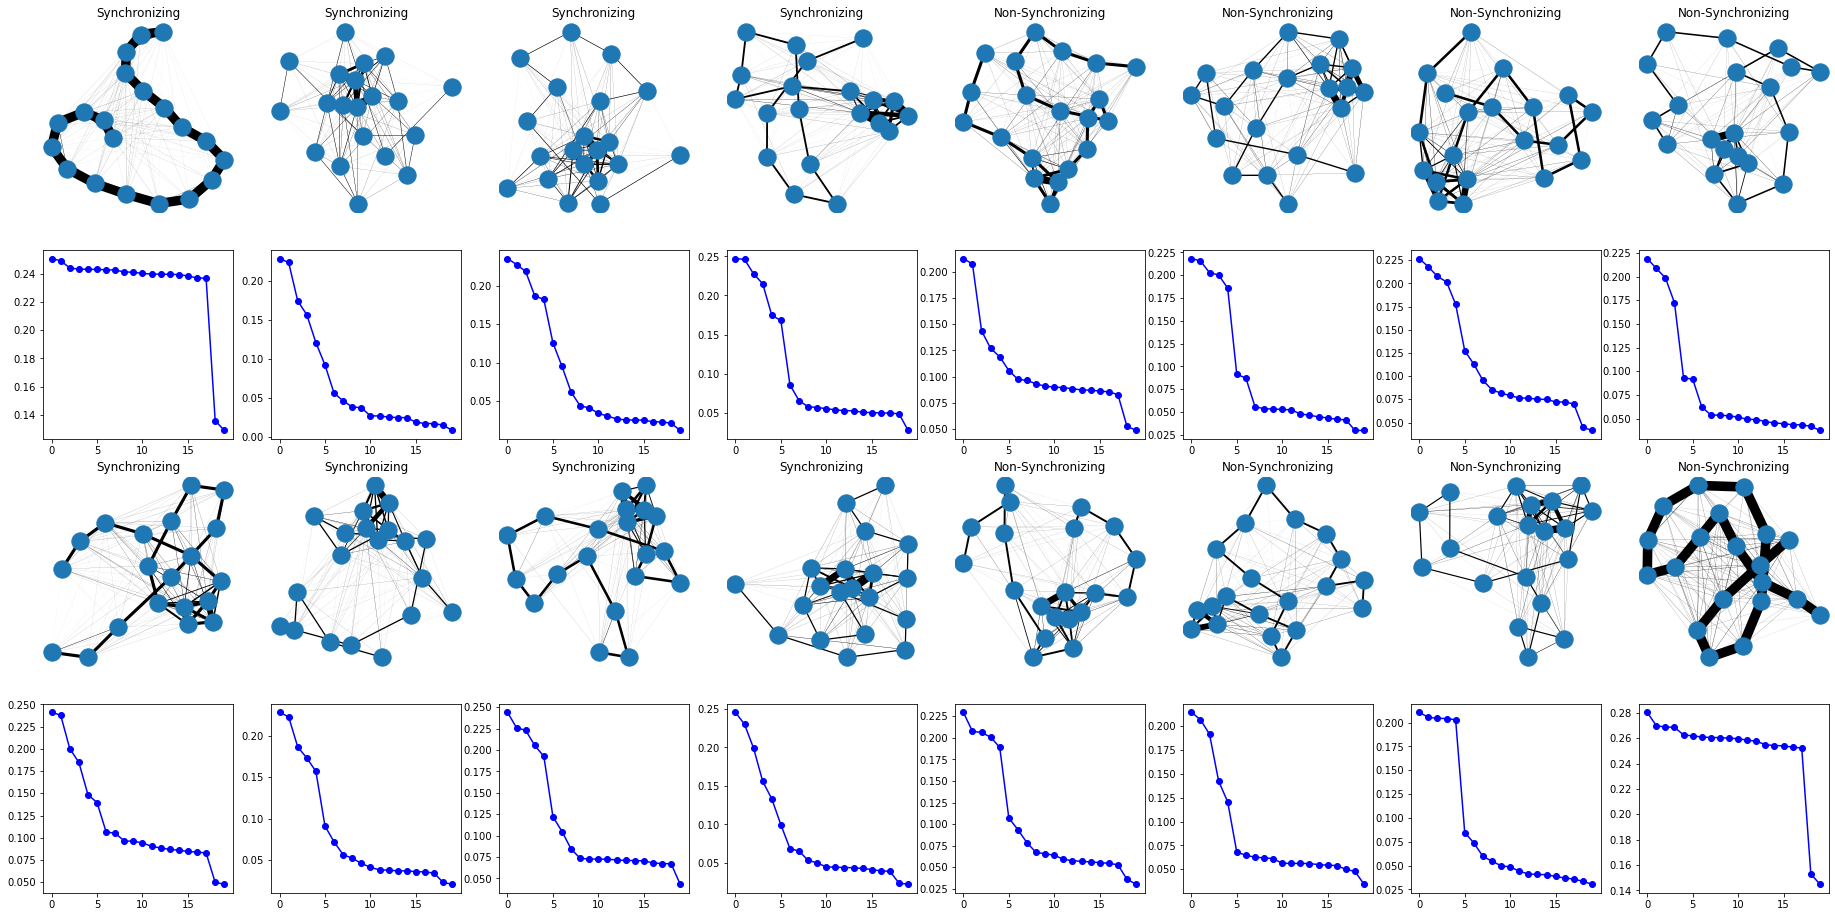

In [13]:
plot_DL_adj_deg(n, True)

## Node2vec

In [14]:
n2v = pd.read_csv("./my_data/UCLA26_20walk_8kappa_node2vec", header = None)

In [15]:
df_original.y

0        True
1        True
2       False
3        True
4        True
        ...  
9995    False
9996     True
9997     True
9998     True
9999    False
Name: y, Length: 10000, dtype: bool

In [16]:
Y_data = df_original.y
df = pd.DataFrame(n2v)

under_sampler = RandomUnderSampler(random_state=42)
X_res, y_res = under_sampler.fit_resample(df, Y_data)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, 
                                                    test_size = 0.2, 
                                                    random_state = 4, 
                                                    stratify = y_res)

In [17]:
xi = 1
iter_avg = 1
beta = 0.5
iteration = 100
r = 10
SNMF_class_new = SNMF(X=[X_train.to_numpy().T, y_train.to_numpy().reshape(-1,1).T],  # data, label
                        X_test=[X_test.to_numpy().T, y_test.to_numpy().reshape(-1,1).T],
                        #X_auxiliary = None,
                        n_components=r,  # =: r = number of columns in dictionary matrices W, W'
                        # ini_loading=None,  # Initializatio for [W,W'], W1.shape = [d1, r], W2.shape = [d2, r]
                        # ini_loading=[W_true, np.hstack((np.array([[0]]), Beta_true))],
                        # ini_code = H_true,
                        xi=xi,  # weight on label reconstruction error
                        L1_reg = [0,0,0], # L1 regularizer for code H, dictionary W[0], reg param W[1]
                        L2_reg = [0,0,0], # L2 regularizer for code H, dictionary W[0], reg param W[1]
                        nonnegativity=[True,True,False], # nonnegativity constraints on code H, dictionary W[0], reg params W[1]
                        full_dim=False)

results_dict_new = SNMF_class_new.train_logistic(iter=iteration, subsample_size=None,
                                                beta = beta,
                                                search_radius_const=np.linalg.norm(X_train),
                                                update_nuance_param=False,
                                                if_compute_recons_error=False, if_validate=False)

  3%|▎         | 3/100 [00:00<00:04, 23.97it/s]

initial loading beta [[ 0.51029658 -0.31276332  0.21759599 -0.92789013  0.12765932  0.60906703
  -0.28658693  0.72878704  0.20568063  0.96692663 -0.88204149]]


100%|██████████| 100/100 [00:03<00:00, 25.79it/s]


In [18]:
results_dict_new

{'xi': 1,
 'L1_reg': [0, 0, 0],
 'L2_reg': [0, 0, 0],
 'nonnegativity': [True, True, False],
 'n_components': 10,
 'loading': [array([[0.        , 0.00096084, 0.03006021, ..., 0.        , 0.        ,
          0.        ],
         [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.        ],
         [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.        ],
         ...,
         [0.        , 0.0409502 , 0.        , ..., 0.        , 0.        ,
          0.        ],
         [0.00017266, 0.        , 0.        , ..., 0.        , 0.        ,
          0.        ],
         [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.        ]]),
  array([[ 0.02683347,  0.23473956, -0.02315595,  0.07237147,  0.32647794,
           0.033474  , -0.52922384,  0.4179396 , -0.33036902,  0.91159326,
           0.25201278]])],
 'code': array([[0.        , 0.43031068, 0.        , ..., 0.88449025, 0.        ,
         0.2

In [19]:
n = 8
W_false, H = ALS(X=pd.DataFrame(n2v)[df_original.y == 0].to_numpy().T, 
           n_components=n, # Reconstruction Error reduces as n_components increases
           n_iter=1000, 
           a0 = 0, # L1 regularizer for H
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           H_nonnegativity=True,
           W_nonnegativity=True,
           compute_recons_error=True,
           subsample_ratio=1)

W_true, H = ALS(X=pd.DataFrame(n2v)[df_original.y != 0].to_numpy().T, 
           n_components=n, # Reconstruction Error reduces as n_components increases
           n_iter=1000, 
           a0 = 0, # L1 regularizer for H
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           H_nonnegativity=True,
           W_nonnegativity=True,
           compute_recons_error=True,
           subsample_ratio=1)

  3%|▎         | 26/1000 [00:00<00:07, 127.32it/s]

iteration 0, reconstruction error 6322.303578
iteration 10, reconstruction error 5426.848068
iteration 20, reconstruction error 5232.723380


  6%|▌         | 58/1000 [00:00<00:06, 144.81it/s]

iteration 30, reconstruction error 5162.367162
iteration 40, reconstruction error 5138.824627
iteration 50, reconstruction error 5122.828720
iteration 60, reconstruction error 5104.753978


  9%|▉         | 89/1000 [00:00<00:06, 150.08it/s]

iteration 70, reconstruction error 5091.279145
iteration 80, reconstruction error 5079.570214
iteration 90, reconstruction error 5071.522017
iteration 100, reconstruction error 5066.747261


 14%|█▎        | 135/1000 [00:00<00:05, 144.95it/s]

iteration 110, reconstruction error 5062.838620
iteration 120, reconstruction error 5059.445728
iteration 130, reconstruction error 5056.572956
iteration 140, reconstruction error 5054.188816


 16%|█▋        | 165/1000 [00:01<00:05, 142.08it/s]

iteration 150, reconstruction error 5052.405878
iteration 160, reconstruction error 5051.219566
iteration 170, reconstruction error 5050.337099


 19%|█▉        | 194/1000 [00:01<00:06, 128.70it/s]

iteration 180, reconstruction error 5049.613203
iteration 190, reconstruction error 5049.212184
iteration 200, reconstruction error 5049.071730


 24%|██▎       | 235/1000 [00:01<00:05, 130.02it/s]

iteration 210, reconstruction error 5049.015625
iteration 220, reconstruction error 5048.989100
iteration 230, reconstruction error 5048.975718


 26%|██▋       | 263/1000 [00:01<00:05, 129.11it/s]

iteration 240, reconstruction error 5048.968839
iteration 250, reconstruction error 5048.965276
iteration 260, reconstruction error 5048.963424


 29%|██▉       | 290/1000 [00:02<00:05, 129.51it/s]

iteration 270, reconstruction error 5048.962458
iteration 280, reconstruction error 5048.961950
iteration 290, reconstruction error 5048.961682


 32%|███▏      | 317/1000 [00:02<00:05, 129.65it/s]

iteration 300, reconstruction error 5048.961540
iteration 310, reconstruction error 5048.961464
iteration 320, reconstruction error 5048.961423


 34%|███▍      | 345/1000 [00:02<00:04, 132.07it/s]

iteration 330, reconstruction error 5048.961402
iteration 340, reconstruction error 5048.961390
iteration 350, reconstruction error 5048.961384


 39%|███▊      | 387/1000 [00:02<00:04, 131.49it/s]

iteration 360, reconstruction error 5048.961380
iteration 370, reconstruction error 5048.961379
iteration 380, reconstruction error 5048.961378


 42%|████▏     | 419/1000 [00:03<00:04, 144.44it/s]

iteration 390, reconstruction error 5048.961377
iteration 400, reconstruction error 5048.961377
iteration 410, reconstruction error 5048.961376
iteration 420, reconstruction error 5048.961376


 45%|████▍     | 449/1000 [00:03<00:03, 137.84it/s]

iteration 430, reconstruction error 5048.961376
iteration 440, reconstruction error 5048.961376
iteration 450, reconstruction error 5048.961376


 48%|████▊     | 480/1000 [00:03<00:03, 143.31it/s]

iteration 460, reconstruction error 5048.961376
iteration 470, reconstruction error 5048.961376
iteration 480, reconstruction error 5048.961376


 51%|█████     | 509/1000 [00:03<00:03, 135.49it/s]

iteration 490, reconstruction error 5048.961376
iteration 500, reconstruction error 5048.961376
iteration 510, reconstruction error 5048.961376


 54%|█████▍    | 538/1000 [00:03<00:03, 133.32it/s]

iteration 520, reconstruction error 5048.961376
iteration 530, reconstruction error 5048.961376
iteration 540, reconstruction error 5048.961376


 57%|█████▋    | 567/1000 [00:04<00:03, 134.23it/s]

iteration 550, reconstruction error 5048.961376
iteration 560, reconstruction error 5048.961376
iteration 570, reconstruction error 5048.961376


 61%|██████    | 610/1000 [00:04<00:02, 135.86it/s]

iteration 580, reconstruction error 5048.961376
iteration 590, reconstruction error 5048.961376
iteration 600, reconstruction error 5048.961376


 62%|██████▏   | 624/1000 [00:04<00:02, 132.85it/s]

iteration 610, reconstruction error 5048.961376
iteration 620, reconstruction error 5048.961376
iteration 630, reconstruction error 5048.961376


 67%|██████▋   | 671/1000 [00:04<00:02, 143.64it/s]

iteration 640, reconstruction error 5048.961376
iteration 650, reconstruction error 5048.961376
iteration 660, reconstruction error 5048.961376
iteration 670, reconstruction error 5048.961376


 70%|███████   | 701/1000 [00:05<00:02, 141.09it/s]

iteration 680, reconstruction error 5048.961376
iteration 690, reconstruction error 5048.961376
iteration 700, reconstruction error 5048.961376


 72%|███████▏  | 716/1000 [00:05<00:02, 137.86it/s]

iteration 710, reconstruction error 5048.961376
iteration 720, reconstruction error 5048.961376


 76%|███████▌  | 756/1000 [00:05<00:02, 119.80it/s]

iteration 730, reconstruction error 5048.961376
iteration 740, reconstruction error 5048.961376
iteration 750, reconstruction error 5048.961376


 78%|███████▊  | 782/1000 [00:05<00:01, 123.00it/s]

iteration 760, reconstruction error 5048.961376
iteration 770, reconstruction error 5048.961376
iteration 780, reconstruction error 5048.961376


 81%|████████  | 809/1000 [00:06<00:01, 127.31it/s]

iteration 790, reconstruction error 5048.961376
iteration 800, reconstruction error 5048.961376
iteration 810, reconstruction error 5048.961376


 84%|████████▎ | 837/1000 [00:06<00:01, 132.11it/s]

iteration 820, reconstruction error 5048.961376
iteration 830, reconstruction error 5048.961376
iteration 840, reconstruction error 5048.961376


 87%|████████▋ | 868/1000 [00:06<00:00, 142.81it/s]

iteration 850, reconstruction error 5048.961376
iteration 860, reconstruction error 5048.961376
iteration 870, reconstruction error 5048.961376
iteration 880, reconstruction error 5048.961376


 92%|█████████▏| 916/1000 [00:06<00:00, 148.25it/s]

iteration 890, reconstruction error 5048.961376
iteration 900, reconstruction error 5048.961376
iteration 910, reconstruction error 5048.961376
iteration 920, reconstruction error 5048.961376


 95%|█████████▍| 948/1000 [00:06<00:00, 152.51it/s]

iteration 930, reconstruction error 5048.961376
iteration 940, reconstruction error 5048.961376
iteration 950, reconstruction error 5048.961376
iteration 960, reconstruction error 5048.961376


100%|█████████▉| 995/1000 [00:07<00:00, 144.47it/s]

iteration 970, reconstruction error 5048.961376
iteration 980, reconstruction error 5048.961376
iteration 990, reconstruction error 5048.961376


  1%|          | 7/1000 [00:00<00:29, 34.21it/s]

iteration 0, reconstruction error 18977.206426


  2%|▏         | 15/1000 [00:00<00:28, 35.13it/s]

iteration 10, reconstruction error 16423.343516


  3%|▎         | 28/1000 [00:00<00:25, 38.50it/s]

iteration 20, reconstruction error 15873.275048


  4%|▎         | 36/1000 [00:00<00:25, 37.97it/s]

iteration 30, reconstruction error 15635.463294


  5%|▍         | 49/1000 [00:01<00:24, 39.21it/s]

iteration 40, reconstruction error 15476.310811


  6%|▌         | 58/1000 [00:01<00:24, 38.75it/s]

iteration 50, reconstruction error 15376.939573


  7%|▋         | 66/1000 [00:01<00:26, 35.50it/s]

iteration 60, reconstruction error 15332.637305


  8%|▊         | 78/1000 [00:02<00:26, 35.31it/s]

iteration 70, reconstruction error 15302.518120


  9%|▊         | 86/1000 [00:02<00:26, 34.84it/s]

iteration 80, reconstruction error 15283.113797


 10%|▉         | 96/1000 [00:02<00:23, 37.81it/s]

iteration 90, reconstruction error 15267.485839


 11%|█         | 106/1000 [00:02<00:23, 38.67it/s]

iteration 100, reconstruction error 15260.702587


 12%|█▏        | 118/1000 [00:03<00:25, 35.18it/s]

iteration 110, reconstruction error 15256.289789


 13%|█▎        | 127/1000 [00:03<00:23, 37.55it/s]

iteration 120, reconstruction error 15252.908065


 14%|█▎        | 136/1000 [00:03<00:22, 38.87it/s]

iteration 130, reconstruction error 15250.571563


 15%|█▍        | 146/1000 [00:03<00:21, 39.11it/s]

iteration 140, reconstruction error 15249.488770


 16%|█▌        | 158/1000 [00:04<00:23, 35.20it/s]

iteration 150, reconstruction error 15249.158476


 17%|█▋        | 166/1000 [00:04<00:24, 34.41it/s]

iteration 160, reconstruction error 15248.997655


 18%|█▊        | 178/1000 [00:04<00:22, 35.95it/s]

iteration 170, reconstruction error 15248.848440


 19%|█▊        | 186/1000 [00:05<00:22, 36.52it/s]

iteration 180, reconstruction error 15248.657185


 20%|█▉        | 198/1000 [00:05<00:22, 35.78it/s]

iteration 190, reconstruction error 15248.377384


 21%|██        | 206/1000 [00:05<00:22, 35.82it/s]

iteration 200, reconstruction error 15247.947136


 22%|██▏       | 218/1000 [00:05<00:21, 35.98it/s]

iteration 210, reconstruction error 15247.274664


 23%|██▎       | 226/1000 [00:06<00:21, 35.71it/s]

iteration 220, reconstruction error 15246.232568


 24%|██▍       | 238/1000 [00:06<00:21, 35.99it/s]

iteration 230, reconstruction error 15244.638005


 25%|██▍       | 246/1000 [00:06<00:21, 35.34it/s]

iteration 240, reconstruction error 15242.232580


 26%|██▌       | 258/1000 [00:07<00:20, 35.43it/s]

iteration 250, reconstruction error 15238.653803


 27%|██▋       | 266/1000 [00:07<00:20, 36.02it/s]

iteration 260, reconstruction error 15234.196879


 28%|██▊       | 278/1000 [00:07<00:20, 35.96it/s]

iteration 270, reconstruction error 15230.414916


 29%|██▊       | 286/1000 [00:07<00:19, 35.76it/s]

iteration 280, reconstruction error 15227.407517


 30%|██▉       | 298/1000 [00:08<00:19, 35.59it/s]

iteration 290, reconstruction error 15224.917344


 31%|███       | 306/1000 [00:08<00:19, 35.49it/s]

iteration 300, reconstruction error 15222.787528


 32%|███▏      | 318/1000 [00:08<00:18, 36.05it/s]

iteration 310, reconstruction error 15220.970813


 33%|███▎      | 326/1000 [00:09<00:18, 36.04it/s]

iteration 320, reconstruction error 15219.408970


 34%|███▍      | 338/1000 [00:09<00:18, 35.83it/s]

iteration 330, reconstruction error 15218.059763


 35%|███▍      | 346/1000 [00:09<00:18, 36.17it/s]

iteration 340, reconstruction error 15216.912555


 36%|███▌      | 358/1000 [00:09<00:17, 35.93it/s]

iteration 350, reconstruction error 15215.956559


 37%|███▋      | 366/1000 [00:10<00:17, 35.83it/s]

iteration 360, reconstruction error 15215.156769


 38%|███▊      | 378/1000 [00:10<00:17, 35.99it/s]

iteration 370, reconstruction error 15214.487528


 39%|███▊      | 386/1000 [00:10<00:17, 35.94it/s]

iteration 380, reconstruction error 15213.929183


 40%|███▉      | 398/1000 [00:11<00:16, 37.10it/s]

iteration 390, reconstruction error 15213.460189


 41%|████      | 406/1000 [00:11<00:16, 37.01it/s]

iteration 400, reconstruction error 15213.055854


 42%|████▏     | 415/1000 [00:11<00:15, 37.46it/s]

iteration 410, reconstruction error 15212.696867


 43%|████▎     | 429/1000 [00:11<00:14, 39.45it/s]

iteration 420, reconstruction error 15212.371603


 44%|████▍     | 438/1000 [00:12<00:14, 39.03it/s]

iteration 430, reconstruction error 15212.070403


 45%|████▍     | 446/1000 [00:12<00:14, 36.98it/s]

iteration 440, reconstruction error 15211.790677


 46%|████▌     | 459/1000 [00:12<00:13, 38.98it/s]

iteration 450, reconstruction error 15211.535664


 47%|████▋     | 467/1000 [00:12<00:14, 37.56it/s]

iteration 460, reconstruction error 15211.299259


 48%|████▊     | 475/1000 [00:13<00:14, 36.89it/s]

iteration 470, reconstruction error 15211.078507


 49%|████▊     | 487/1000 [00:13<00:14, 35.07it/s]

iteration 480, reconstruction error 15210.873114


 50%|████▉     | 496/1000 [00:13<00:14, 35.11it/s]

iteration 490, reconstruction error 15210.681071


 51%|█████     | 506/1000 [00:13<00:12, 38.13it/s]

iteration 500, reconstruction error 15210.498240


 52%|█████▏    | 515/1000 [00:14<00:12, 37.44it/s]

iteration 510, reconstruction error 15210.321379


 53%|█████▎    | 527/1000 [00:14<00:13, 36.36it/s]

iteration 520, reconstruction error 15210.146090


 54%|█████▎    | 535/1000 [00:14<00:13, 34.24it/s]

iteration 530, reconstruction error 15209.970303


 55%|█████▍    | 548/1000 [00:15<00:12, 37.27it/s]

iteration 540, reconstruction error 15209.791550


 56%|█████▌    | 557/1000 [00:15<00:11, 38.55it/s]

iteration 550, reconstruction error 15209.602105


 56%|█████▋    | 565/1000 [00:15<00:11, 37.71it/s]

iteration 560, reconstruction error 15209.388875


 58%|█████▊    | 577/1000 [00:15<00:11, 36.86it/s]

iteration 570, reconstruction error 15209.136618


 58%|█████▊    | 585/1000 [00:16<00:11, 37.05it/s]

iteration 580, reconstruction error 15208.811398


 60%|█████▉    | 599/1000 [00:16<00:10, 38.44it/s]

iteration 590, reconstruction error 15208.326472


 61%|██████    | 607/1000 [00:16<00:10, 37.25it/s]

iteration 600, reconstruction error 15207.454684


 62%|██████▏   | 615/1000 [00:16<00:11, 34.86it/s]

iteration 610, reconstruction error 15205.683936


 63%|██████▎   | 628/1000 [00:17<00:09, 38.15it/s]

iteration 620, reconstruction error 15202.500458


 64%|██████▎   | 637/1000 [00:17<00:09, 39.38it/s]

iteration 630, reconstruction error 15200.574033


 65%|██████▍   | 646/1000 [00:17<00:09, 39.00it/s]

iteration 640, reconstruction error 15199.508751


 66%|██████▌   | 658/1000 [00:18<00:09, 37.17it/s]

iteration 650, reconstruction error 15198.784615


 67%|██████▋   | 667/1000 [00:18<00:08, 37.54it/s]

iteration 660, reconstruction error 15198.286264


 68%|██████▊   | 675/1000 [00:18<00:09, 35.14it/s]

iteration 670, reconstruction error 15197.941199


 69%|██████▉   | 688/1000 [00:18<00:08, 37.71it/s]

iteration 680, reconstruction error 15197.700929


 70%|██████▉   | 696/1000 [00:19<00:09, 31.80it/s]

iteration 690, reconstruction error 15197.530871


 70%|███████   | 704/1000 [00:19<00:09, 32.34it/s]

iteration 700, reconstruction error 15197.405412


 72%|███████▏  | 717/1000 [00:19<00:08, 32.44it/s]

iteration 710, reconstruction error 15197.306922


 72%|███████▎  | 725/1000 [00:20<00:08, 31.19it/s]

iteration 720, reconstruction error 15197.224022


 74%|███████▍  | 739/1000 [00:20<00:07, 37.21it/s]

iteration 730, reconstruction error 15197.149421


 75%|███████▍  | 748/1000 [00:20<00:06, 39.37it/s]

iteration 740, reconstruction error 15197.078393


 76%|███████▌  | 756/1000 [00:20<00:06, 38.77it/s]

iteration 750, reconstruction error 15197.007618


 76%|███████▋  | 764/1000 [00:21<00:07, 32.33it/s]

iteration 760, reconstruction error 15196.934694


 78%|███████▊  | 778/1000 [00:21<00:05, 37.83it/s]

iteration 770, reconstruction error 15196.857921


 79%|███████▊  | 786/1000 [00:21<00:05, 36.73it/s]

iteration 780, reconstruction error 15196.775966


 80%|███████▉  | 798/1000 [00:22<00:05, 35.96it/s]

iteration 790, reconstruction error 15196.687799


 81%|████████  | 806/1000 [00:22<00:05, 34.67it/s]

iteration 800, reconstruction error 15196.592774


 82%|████████▏ | 816/1000 [00:22<00:04, 37.36it/s]

iteration 810, reconstruction error 15196.490588


 83%|████████▎ | 826/1000 [00:22<00:04, 39.22it/s]

iteration 820, reconstruction error 15196.380576


 84%|████████▎ | 836/1000 [00:23<00:04, 39.60it/s]

iteration 830, reconstruction error 15196.261903


 84%|████████▍ | 845/1000 [00:23<00:03, 38.82it/s]

iteration 840, reconstruction error 15196.133827


 85%|████████▌ | 854/1000 [00:23<00:04, 34.98it/s]

iteration 850, reconstruction error 15195.995293


 87%|████████▋ | 866/1000 [00:23<00:03, 33.83it/s]

iteration 860, reconstruction error 15195.845302


 88%|████████▊ | 879/1000 [00:24<00:03, 35.83it/s]

iteration 870, reconstruction error 15195.684024


 89%|████████▉ | 888/1000 [00:24<00:02, 38.21it/s]

iteration 880, reconstruction error 15195.510206


 90%|████████▉ | 897/1000 [00:24<00:02, 39.19it/s]

iteration 890, reconstruction error 15195.323262


 90%|█████████ | 905/1000 [00:24<00:02, 37.03it/s]

iteration 900, reconstruction error 15195.123067


 92%|█████████▏| 917/1000 [00:25<00:02, 35.96it/s]

iteration 910, reconstruction error 15194.907527


 92%|█████████▎| 925/1000 [00:25<00:02, 35.31it/s]

iteration 920, reconstruction error 15194.674230


 94%|█████████▍| 938/1000 [00:25<00:01, 37.76it/s]

iteration 930, reconstruction error 15194.422761


 95%|█████████▍| 946/1000 [00:26<00:01, 36.51it/s]

iteration 940, reconstruction error 15194.165834


 96%|█████████▌| 956/1000 [00:26<00:01, 37.92it/s]

iteration 950, reconstruction error 15193.929812


 96%|█████████▋| 965/1000 [00:26<00:00, 37.50it/s]

iteration 960, reconstruction error 15193.759101


 98%|█████████▊| 978/1000 [00:26<00:00, 38.45it/s]

iteration 970, reconstruction error 15193.650077


 99%|█████████▊| 987/1000 [00:27<00:00, 39.32it/s]

iteration 980, reconstruction error 15193.584357


100%|█████████▉| 996/1000 [00:27<00:00, 39.41it/s]

iteration 990, reconstruction error 15193.550936


100%|██████████| 1000/1000 [00:27<00:00, 36.33it/s]


array([[<AxesSubplot:title={'center':'0'}>,
        <AxesSubplot:title={'center':'1'}>,
        <AxesSubplot:title={'center':'2'}>],
       [<AxesSubplot:title={'center':'3'}>,
        <AxesSubplot:title={'center':'4'}>,
        <AxesSubplot:title={'center':'5'}>],
       [<AxesSubplot:title={'center':'6'}>,
        <AxesSubplot:title={'center':'7'}>, <AxesSubplot:>]], dtype=object)

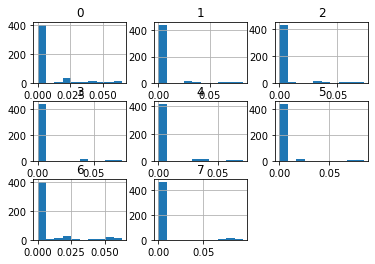

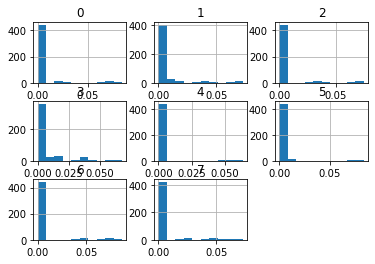

In [20]:
pd.DataFrame(W_false).describe()
pd.DataFrame(W_true).describe()
pd.DataFrame(W_false).hist()
pd.DataFrame(W_true).hist()